In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy
from sklearn import preprocessing, cluster 
%matplotlib inline

In [5]:
conn  = sqlalchemy.create_engine('postgresql:///yelp')

In [9]:
def reader( data ):
# read the entire file into a python array

    # remove the trailing "\n" from each line
    data = map(lambda x: x.rstrip(), data)

    # each element of 'data' is an individual JSON object.
    # i want to convert it into an *array* of JSON objects
    # which, in and of itself, is one large JSON object
    # basically... add square brackets to the beginning
    # and end, and have all the individual business JSON objects
    # separated by a comma
    data_json_str = "[" + ','.join(data) + "]"

    # now, load it into pandas
    return pd.read_json(data_json_str)


Read in the review dataset

In [ ]:
data = open('./data/yelp_academic_dataset_review.json').readlines()
step = range(0,len(data),100000)
i=0
while i < len(step):
    if i%10 == 0: print step[i], 'to', step[i+1]
    df = reader(data[step[i]:step[i+1]])
    print df.head()
    df[['user_id', 'business_id','date','stars']].to_sql('reviews',conn, if_exists='append')
    i+=1



Read in the business dataset

In [14]:
data = open('./data/yelp_academic_dataset_business.json').readlines()
df = reader( data )
price = df[df.attributes.apply(lambda x: 'Price Range' in x.keys() )]
price['cost'] = price.attributes.apply(lambda x: x['Price Range'] )
price[['business_id','review_count','stars','cost']].to_sql('business',conn, if_exists='append')

Read in the reviwer dataset

In [11]:
data = open('./data/yelp_academic_dataset_user.json').readlines()
df = reader( data )
df[['user_id','average_stars']].to_sql('person',conn, if_exists='append')

### Now compare reviewer averages with business averages

In [17]:
queryString = """

SELECT t1.uid, t1.theReview, t1.avgPerRev, b.stars as avgBusRev, b.cost
FROM

(SELECT p.average_stars as avgPerRev, r.stars as theReview, r.business_id, p.user_id as uid
FROM reviews as r
INNER JOIN person as p
ON p.user_id = r.user_id ) as t1

INNER JOIN business as b
ON t1.business_id = b.business_id

"""


In [18]:
review_data = pd.read_sql_query(queryString, conn)

In [22]:
review_data.head()

,uid,thereview,avgperrev,avgbusrev,cost
0,pEVf8GRshP9HUkSpizc9LA,2,3.96,4.0,2
1,uZbTb-u-GVjTa2gtQfry5g,4,3.85,4.0,2
2,HOaWRV72ZQs0me1geSqBzg,5,3.93,5.0,1
3,pEVf8GRshP9HUkSpizc9LA,4,3.96,3.5,2
4,Mn9YYbeY_ydJ7NABALyYIQ,2,3.42,3.5,2


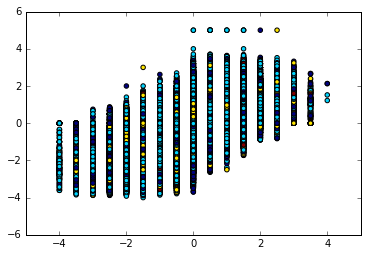

In [33]:
plt.scatter( review_data.thereview - review_data.avgbusrev,
             review_data.thereview - review_data.avgperrev,
             c = review_data.cost
           )

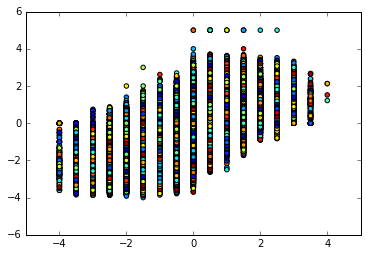

In [34]:
plt.scatter( review_data.thereview - review_data.avgbusrev,
             review_data.thereview - review_data.avgperrev,
             c = preprocessing.LabelEncoder().fit_transform( review_data.uid )
           )

In [35]:
review_data.groupby('uid').agg({'thereview':len}).describe()

,thereview
count,490728.000000
mean,3.913382
std,13.035267
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,1189.000000
